#   IAU Zadanie - Aktivita na cviceni

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

### Import vsetkych potrebnych kniznic

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Pre prácu s obrazkami
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

## 4.1.A

### EDA

#### Základne informácie o datasete

In [13]:
df = pd.read_csv('faces/train.csv')

# Zobrazenie informácií o datasete
print("Dataset info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None

First 5 rows:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


#### Analýza distribúcie tried


Class distribution:
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


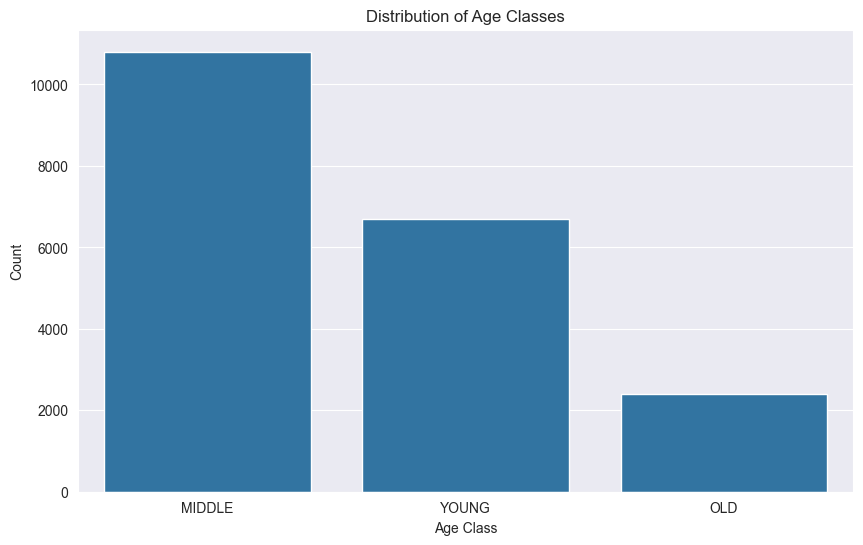

In [14]:
class_distribution = df['Class'].value_counts()
print("\nClass distribution:")
print(class_distribution)

# Vizualizácia distribúcie
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Distribution of Age Classes')
plt.ylabel('Count')
plt.xlabel('Age Class')
plt.show()

Vzhľadom na to, že máme nepomer tried, tak nastavíme pri trénovaní rozdielne váhy pre triedy aby sme optimalizovali učenie modelov.

#### Analýza obrazkov

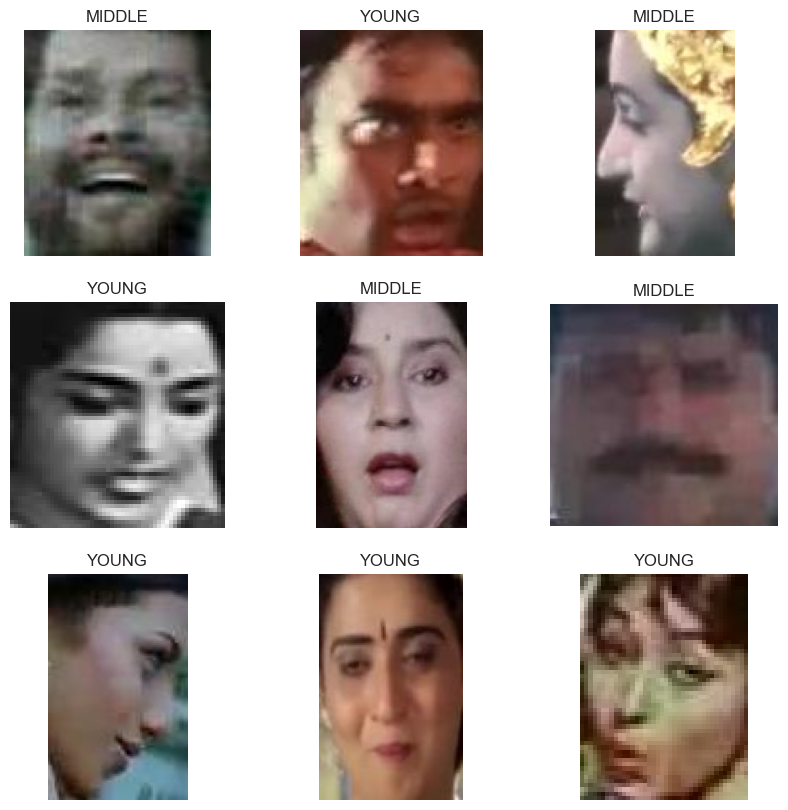

In [15]:
# Zobrazenie niekoľkých obrázkov
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join('faces/train', df['ID'][i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
    plt.title(df['Class'][i])
    plt.axis('off')
plt.show()

#### Ako mozme vidiet, obrazky nie su rovnakej velkosti a nemaju rovnaku kvalitu, tak musime spravit nejaky preproccesing

### Preprocessing

#### V tomto kode
- Štandardizujeme veľkosť všetkých obrázkov
- Normalizujeme hodnoty pixelov do rozsahu 0-1
- Rozdelíme dataset na trénovaciu a validačnú časť
- Vytvoríme efektívny generátor dát pre trénovanie

In [16]:
# Definujeme konštanty pre preprocessing
TARGET_SIZE = (224, 224)  # štandardná veľkosť pre mnohé CNN architektúry
BATCH_SIZE = 64

# Enkódovanie labelov
label_encoder = LabelEncoder()
df['Class_encoded'] = label_encoder.fit_transform(df['Class'])

df.head(10)

,ID,Class,Class_encoded
0,377.jpg,MIDDLE,0
1,17814.jpg,YOUNG,2
2,21283.jpg,MIDDLE,0
3,16496.jpg,YOUNG,2
4,4487.jpg,MIDDLE,0
5,6283.jpg,MIDDLE,0
6,23495.jpg,YOUNG,2
7,7100.jpg,YOUNG,2
8,6028.jpg,YOUNG,2
9,22617.jpg,OLD,1


In [17]:
# # Vytvorenie funkcie na preprocessing obrázkov
# def preprocess_image(image_path, target_size=TARGET_SIZE):
#     img_path = os.path.join('faces/train', image_path)
#     img = cv2.imread(img_path)
#     if img is None:
#         print(f"Warning: Image {image_path} not found.")
#         return None
#
#     # Konverzia z BGR do RGB
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#
#     # Resize na štandardnú veľkosť
#     img = cv2.resize(img, target_size)
#
#     # Normalizácia hodnôt na rozsah 0-1
#     img = img / 255.0
#
#     return img
#
# # Testovanie preprocessing funkcie na jednom obrázku
# sample_img = preprocess_image(df['ID'].iloc[0])
# if sample_img is not None:
#     plt.figure(figsize=(5,5))
#     plt.imshow(sample_img)
#     plt.title(f"Preprocessed image\nShape: {sample_img.shape}")
#     plt.axis('off')
#     plt.show()

In [18]:
# Rozdelenie na tréning, validačnú a testovaciu množinu
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class'], random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Training set size: 13934
Validation set size: 2986
Test set size: 2986


In [19]:
# # Vytvorenie data generátora pre efektívne načítanie dát
# class ImageDataGenerator:
#     def __init__(self, dataframe, batch_size=BATCH_SIZE, is_training=True):
#         self.df = dataframe
#         self.batch_size = batch_size
#         self.is_training = is_training
#
#     def __len__(self):
#         return len(self.df) // self.batch_size
#
#     def generate_batch(self):
#         while True:
#             indices = np.random.permutation(len(self.df))
#             for start in range(0, len(indices), self.batch_size):
#                 batch_indices = indices[start:start + self.batch_size]
#                 batch_df = self.df.iloc[batch_indices]
#
#                 batch_images = []
#                 batch_labels = []
#
#                 for _, row in batch_df.iterrows():
#                     img = preprocess_image(row['ID'])
#                     if img is not None:
#                         batch_images.append(img)
#                         batch_labels.append(row['Class_encoded'])
#
#                 if batch_images:  # ak máme aspoň jeden platný obrázok
#                     yield np.array(batch_images), np.array(batch_labels)
#
# # Vytvorenie generátorov pre tréning a validáciu
# train_generator = ImageDataGenerator(train_df)
# val_generator = ImageDataGenerator(val_df, is_training=False)
#
# # Test generátora - zobrazenie jednej dávky
# test_batch_images, test_batch_labels = next(train_generator.generate_batch())
# print("Batch shape:", test_batch_images.shape)
# print("Labels shape:", test_batch_labels.shape)
#
# # Zobrazenie niekoľkých preprocessovaných obrázkov z dávky
# plt.figure(figsize=(15, 5))
# for i in range(5):
#     plt.subplot(1, 5, i+1)
#     plt.imshow(test_batch_images[i])
#     plt.title(label_encoder.inverse_transform([test_batch_labels[i]])[0])
#     plt.axis('off')
# plt.show()

Found 13934 validated image filenames belonging to 3 classes.
Found 2986 validated image filenames belonging to 3 classes.
Found 2986 validated image filenames belonging to 3 classes.


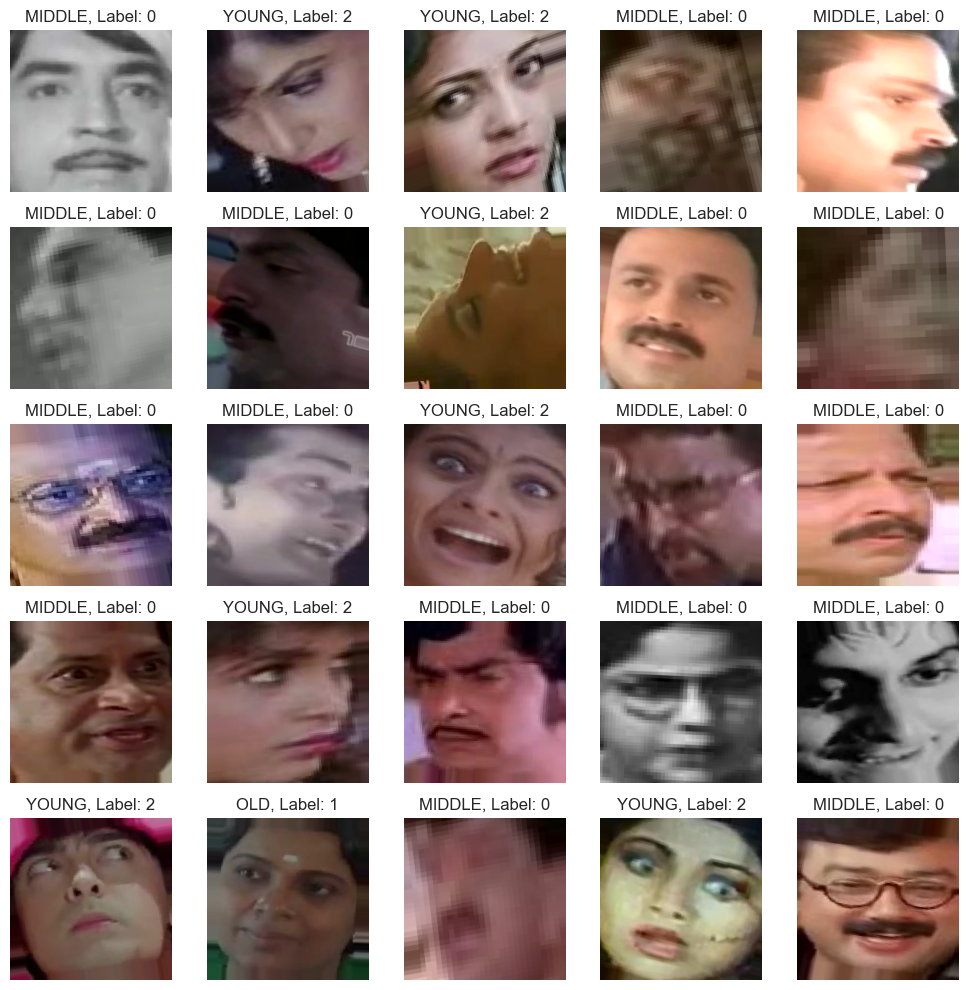

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definícia augmentačného generátora pre tréning
train_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalizácia pixelov na rozsah 0-1
    horizontal_flip=True,  # Horizontálne zrkadlenie s pravdepodobnosťou 50%
    rotation_range=15,  # Rotácia do ±15 stupňov
    brightness_range=(0.8, 1.2),  # Jemná úprava jasu
    zoom_range=0.2,  # Náhodné priblíženie/oddialenie
    shear_range=0.2,  # Náklon obrázkov
    fill_mode="nearest"  # Vyplnenie okrajov pri transformáciách
)

# Generátor len pre normalizáciu na validačné a testovacie dáta
val_test_normalization = ImageDataGenerator(rescale=1.0 / 255)

# Tréningový generátor
train_gen = train_augmentation.flow_from_dataframe(
    dataframe=train_df,
    directory="faces/train",
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,  # Rozmery obrázkov
    batch_size=BATCH_SIZE,
    class_mode="categorical",  # Kategórie (jedno-hot encoding)
    shuffle=True  # Náhodné miešanie dávok
)

# Validačný generátor (len normalizácia)
val_gen = val_test_normalization.flow_from_dataframe(
    dataframe=val_df,
    directory="faces/train",
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# Testovací generátor (len normalizácia, nemieša poradie)
test_gen = val_test_normalization.flow_from_dataframe(
    dataframe=test_df,
    directory="faces/train",
    x_col="ID",
    y_col="Class",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Zachovanie poradia pre presné vyhodnotenie
)

augmented_images, labels = next(train_gen)  # Získa jednu dávku obrázkov z generátora

# Zobrazenie 5x5 => 25 augmentovaných obrázkov
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(label_encoder.inverse_transform([np.argmax(labels[i])])[0] + ", Label: " + str(np.argmax(labels[i])))
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4.1.B

### Pre Age Detection dataset navrhujeme použiť Konvolučnú neurónovú sieť (CNN), konkrétne architektúru založenú na ResNet50. Zdôvodnenie výberu:

#### Charakter dát:

- Pracujeme s obrázkami tvárí
- Máme 3 triedy (YOUNG, MIDDLE, OLD)
- Dataset obsahuje veľké množstvo vzoriek (19906 obrázkov)
- Obrázky majú rôznu kvalitu a veľkosť


#### Prečo CNN?

- CNN sú špecializované na spracovanie obrazových dát
- Automaticky sa učia hierarchiu príznakov - od jednoduchých hrán až po komplexné vzory
- Dokážu si poradiť s variabilitou v pozícii a veľkosti príznakov
- Sú robustné voči menším zmenám v obrázkoch


#### Prečo konkrétne ResNet50:

- Hlboká architektúra umožňuje zachytiť komplexné vzory starnutia
- Residuálne spojenia pomáhajú s problémom miznúceho gradientu
- Je predtrénovaná na ImageNet, čo umožňuje transfer learning
- Dokázala svoju efektivitu v podobných úlohách klasifikácie tvárí


#### Alternatívy, ktoré boli zvážené:

- VGG16/19: Jednoduchšia architektúra, ale náchylnejšia na preučenie
- MobileNet: Ľahšia architektúra, ale môže byť nedostatočne komplexná
- Custom CNN: Potrebovala by dlhší čas na tréning a ladenie

## 4.2.A

### Vytvorenie modelu Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger
from sklearn.utils.class_weight import compute_class_weight

# Initialize W&B
wandb.init(
    project="age-detection",
    config={
        "model_name": "Xception",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "dropout_rate": 0.5,
        "dense_units": 256,
        "learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 20,
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

# Define Xception Model
def create_xception(input_shape, num_classes, dropout_rate, dense_units):
    # Load Xception as base model
    base_model = Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),                       # Pooling layer
        Dropout(dropout_rate),                          # Dropout for regularization
        Dense(dense_units, activation="relu"),          # Fully connected layer
        Dropout(dropout_rate),                          # Additional dropout
        Dense(num_classes, activation="softmax")        # Output layer for classification
    ])
    return model

# Create the model
model = create_xception(
    input_shape=config.input_shape,
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate,
    dense_units=config.dense_units
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=config.metrics
)

# Callbacks
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(filepath=".keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["Class_encoded"]),
    y=train_df["Class_encoded"]
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

print('\n')
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

### Predikcia modelu Xceptron


In [ ]:
test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("ResNet50 - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()

### Vytvorenie modelu ResNet50

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger

from sklearn.utils.class_weight import compute_class_weight

# Inicializácia W&B pre logovanie
wandb.init(
    project="age-detection",
    config={
        "model_name": "ResNet50",
        "input_shape": (224, 224, 3),
        "num_classes": 3,
        "dropout_rate": 0.3,
        "dense_units": 256,
        "learning_rate": 1e-4,
        "batch_size": BATCH_SIZE,
        "epochs": 20,
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
)

config = wandb.config

# Definícia modelu ResNet50
def create_resnet50(input_shape, num_classes, dropout_rate, dense_units):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Zmrazíme predtrénované váhy
    # # Unfreeze the last few layers of the ResNet50 base model
    # for layer in base_model.layers[-10:]:  # Adjust number of layers to unfreeze
    #     layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),                       # Priemerovanie výstupu
        Dropout(dropout_rate),                          # Regularizácia
        Dense(dense_units, activation="relu"),          # Pridaná plne spojená vrstva
        Dropout(dropout_rate),                          # Regularizácia
        Dense(num_classes, activation="softmax")        # Výstupná vrstva pre klasifikáciu
    ])
    return model

# Vytvorenie modelu
model = create_resnet50(
    input_shape=config.input_shape,
    num_classes=config.num_classes,
    dropout_rate=config.dropout_rate,
    dense_units=config.dense_units
)

# Kompilácia modelu
model.compile(
    # optimizer=Adam(learning_rate=config.learning_rate),
    optimizer=SGD(learning_rate=config.learning_rate, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacky pre tréning
callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    WandbModelCheckpoint(filepath=".keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# # Vypočet vah tried
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(train_df["Class_encoded"]),
#     y=train_df["Class_encoded"]
# )
# class_weights = dict(enumerate(class_weights))

# Tréning modelu
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    # class_weight=class_weights,
    callbacks=callbacks
)

print('\n')
# Hodnotenie na validačnej množine
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print('\n')
# Hodnotenie na testovacej množine
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Zobrazenie grafov tréningu
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

wandb.finish()

C:\Users\frede\PycharmProjects\IAU_zadanie\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 29/218 ━━━━━━━━━━━━━━━━━━━━ 32:09 10s/step - accuracy: 0.4677 - loss: 1.5218

KeyboardInterrupt: 

### Predikcia modelu RestNet50

In [ ]:
test_images, test_labels = next(test_gen)  # Získa jednu dávku obrázkov z test generátora

# Predikcia
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Enkódnutie tried do čitatelnej podoby
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class'])
class_names = label_encoder.classes_

# Zobrazenie 5x5 => 25 obrázkov s predikovanými a realnymmi hodnotami
plt.figure(figsize=(10, 10))
plt.suptitle("ResNet50 - Age Recognition Predictions", fontsize=20)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(
        f"Predicted: {class_names[predicted_labels[i]]}\n"
        f"Actual: {class_names[true_labels[i]]}",
        color="green" if predicted_labels[i] == true_labels[i] else "red"
    )

plt.tight_layout()
plt.show()